In [1]:
import os.path as osp
import sys, os
sys.path.insert(0, '..')
import time


import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torch_geometric.datasets import MNISTSuperpixels
# import torch_geometric.transforms as T
# from torch_geometric.data import DataLoader
# from torch_geometric.utils import normalized_cut
# from torch_geometric.nn import (NNConv, graclus, max_pool, max_pool_x,
#                                 global_mean_pool)
__file__ = osp.abspath('')


#####
# aux libs
from skimage import color

from lib.segmentation import extract_features_fixed
# from lib.segmentation import slic_fixed
from lib.segmentation import quickshift_fixed
from lib.pipeline import preprocess_pipeline_fixed
from tqdm import tqdm

# Reading the M2NIST dataset

In [2]:
segmented = np.load("../data/M2NIST/segmented.npy")
_, HEIGHT, WIDTH, N_CLASSES = segmented.shape
mask = 1-segmented[:,:,:,-1]
combined = np.load("../data/M2NIST/combined.npy").reshape((-1, HEIGHT, WIDTH, 1))/255

FileNotFoundError: [Errno 2] No such file or directory: '../data/M2NIST/segmented.npy'

In [ ]:
for i in range(2):
    plt.figure()
    image = segmented[i]
    for ii in range(0,11):
        plt.subplot(3,4,ii+1)
        plt.imshow(image[:,:,ii])

In [ ]:
plt.imshow(combined[0][:,:,0])

# Reading the monet dataset

In [ ]:
path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'MNIST')
train_dataset = MNISTSuperpixels(path, True, transform=None)
test_dataset = MNISTSuperpixels(path, False, transform=T.Cartesian())
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
d = train_dataset

In [ ]:
print(d[0].x)
# for v in zip(d[0].pos,d[0].x):
#     print(v)

In [ ]:
print(d[0])
pos_x = d[0].pos[:,0].numpy()
pos_y = d[0].pos[:,1].numpy()
coo_matrix = d[0].edge_index 

for i in range(d[0].num_edges):
    ii, jj = coo_matrix[0,i], coo_matrix[1,i]
    plt.plot([pos_x[ii],pos_x[jj]],[pos_y[ii],pos_y[jj]],'k-',alpha=0.1)
plt.plot(pos_x, pos_y, 'ro')


The dataset is composed from the tensors stored as: 
* x:N x 75 nodes
* y: N x 1 labels
* edge_index: 2 x 83 Mio... 2 COO elements concatenated 
* edege_slice: 1 x N+1... start and end of the slices
* pos: N x 75 x 2 ... polar coordinates of the position of the 75 nodes in the image



# Patch Generator

In [10]:
class PatchGen(object):
    def __init__(self,patch_size=21):
#         assert(patch_size%2==1)
        self.patch_size = patch_size
                 
    def transform(self,im,padding=2):
        p = self.patch_size
        padding = p//2
        im_pad = np.pad(im,((padding,padding),(padding,padding),(0,0)),mode='constant')
        m,n = im.shape[0], im.shape[1]
        patches = []
        for i,j in zip(range(n),range(m)):
            patch = im_pad[i:i+p,j:j+p,:]
            patches.append(patch)
#             patch = im_pad[i:i+p,j:j+p,:]
#             patches.append(np.expand_dims(patch,axis=-1))
        return patches


In [11]:
padgen = PatchGen()
u = combined[10]


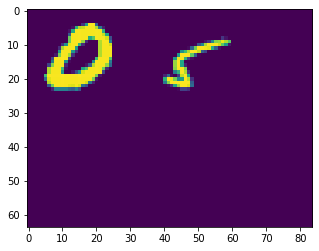

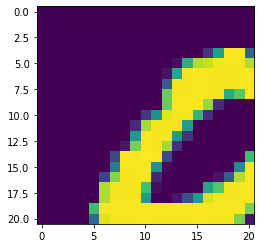

In [12]:
w = padgen.transform(u)
plt.figure()
plt.imshow(u[:,:,0])
plt.figure()
plt.imshow(w[10].squeeze())

# for ww in w[0:20]:
#     plt.figure()
#     plt.imshow(ww.squeeze())
#     plt.show()

# Graph generator

In [13]:
# auxiliary functions
from skimage import segmentation as segment, draw
from skimage.measure import regionprops
from skimage.future import graph

def _scale(image, scale=8):
    if scale == 1:
        return image
    else:
        image = np.repeat(image, scale, axis=0)
        image = np.repeat(image, scale, axis=1)
        return image
    
    
def _segment_with_mean(image, segmentation):
    mean_image = np.zeros_like(image)
    props = regionprops(segmentation + 1)
    
    for i, prop in enumerate(props):
        min_row, min_col, max_row, max_col = prop['bbox']
        sliced_image = image[min_row:max_row, min_col:max_col]
        color = sliced_image[prop['image']].mean(axis=0)
        
        for row, col in prop['coords']:
            mean_image[row, col] = color
        
    return mean_image


def draw_rag(image, segmentation):
    rag = graph.rag_mean_color(image, segmentation)    
    offset = 1
    map_array = np.arange(segmentation.max() + 1)
    for n, d in rag.nodes(data=True):
        for label in d['labels']:
            map_array[label] = offset
        offset += 1

    rag_labels = map_array[segmentation]
    regions = regionprops(rag_labels)
    for (n, data), region in zip(rag.nodes(data=True), regions):
        data['centroid'] = region['centroid']
    
    out = image.copy()
    
    for n1, n2, data in rag.edges(data=True):
        r1, c1 = map(int, rag.node[n1]['centroid'])
        r2, c2 = map(int, rag.node[n2]['centroid'])
        line = draw.line(r1, c1, r2, c2)
        out[line] = [1, 0, 0]
        
    for n, d in rag.nodes(data=True):
        r, c = map(int, rag.node[n]['centroid'])
        if r > 1 and c > 1 and r < image.shape[0] - 1 and c < image.shape[1] - 1:
            circle = draw.circle(r, c, 2)
            out[circle] = [0, 1, 0]
        
    return out


def showcase_image_segmentation(image, segmentation, duration, scale=8):  
    print('Execution time: {:.5f}s'.format(duration))
    print('Number of segments:', np.unique(segmentation).shape[0])
    
    image = _scale(image, scale)
    segmentation = _scale(segmentation, scale)
    
    fig = plt.figure()
    fig.add_subplot(221)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)
    fig.add_subplot(222)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(segment.mark_boundaries(image, segmentation, (1, 0, 0)))
    fig.add_subplot(223)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(_segment_with_mean(image, segmentation))
    fig.add_subplot(224)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(draw_rag(image, segmentation))
    
    plt.show()

In [14]:
from skimage.segmentation import slic, quickshift

In [15]:
image_test = w[10].squeeze()#combined[0][:,:,0]
image_test = color.gray2rgb(image_test)
image_test.shape
# image_test = color.gray2rgb(np.reshape(image_test, (28, 28)))

(21, 21, 3)

## RAG generation of the m2nist with the slic algorithm

Execution time: 0.00754s
Number of segments: 75


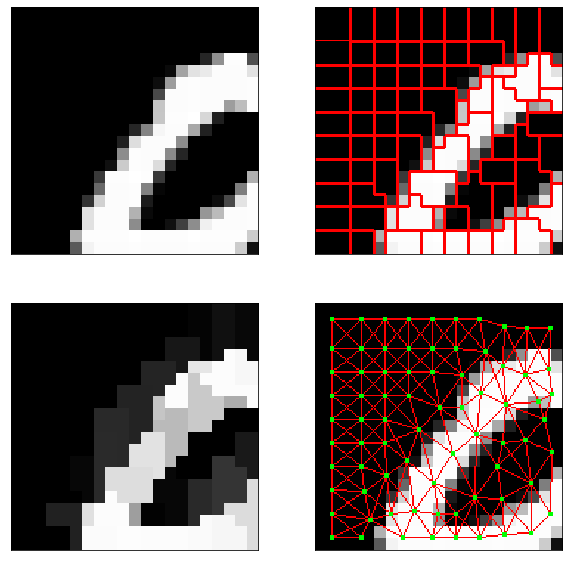

In [16]:
t_start = time.process_time()

segmentation = slic(image_test, n_segments=75, compactness=5, max_iter=100, sigma=0)
duration = time.process_time() - t_start

plt.rcParams['figure.figsize'] = (10, 10)
showcase_image_segmentation(image_test, segmentation, duration)

In [17]:
segmentation.shape

(21, 21)

## RAG generation of the m2nist with the quickshift  algorithm

Execution time: 0.00445s
Number of segments: 59


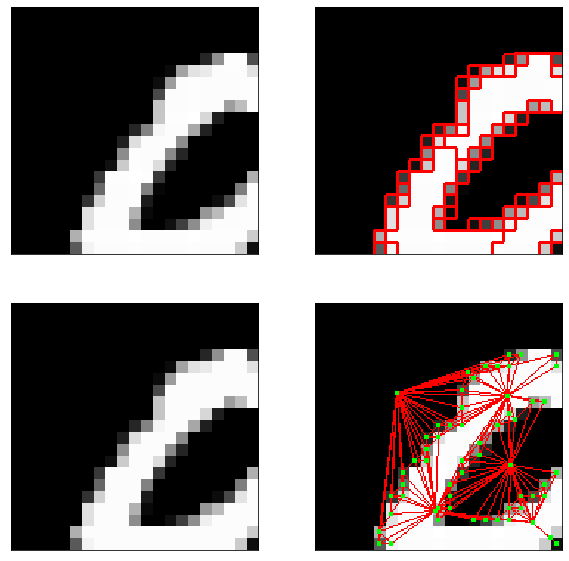

In [18]:
t_start = time.process_time()
segmentation = quickshift(image_test, ratio=1, kernel_size=2, max_dist=2, sigma=0)
duration = time.process_time() - t_start

plt.rcParams['figure.figsize'] = (10, 10)
showcase_image_segmentation(image_test, segmentation, duration)

## creating the ghaphs

In [19]:
# constants
# QUICKSHIFT_FEATURES = [4, 6, 7, 8, 24, 28, 29, 31, 37]
# FORM_FEATURES = QUICKSHIFT_FEATURES

# LEVELS = 4
# CONNECTIVITY = 8
# SCALE_INVARIANCE = False
# STDDEV = 1
# segmentation_algorithm = quickshift_fixed(ratio=1, kernel_size=2, max_dist=2, sigma=0)

padgen = PatchGen()
segmentation_algorithm = lambda x: slic(x, n_segments=75, max_iter=50)
def graph_maker(image, labels):
    def _weight_mean_color(graph, src, dst, n):
        """Callback to handle merging nodes by recomputing mean color.

        The method expects that the mean color of `dst` is already computed.

        Parameters
        ----------
        graph : RAG
            The graph under consideration.
        src, dst : int
            The vertices in `graph` to be merged.
        n : int
            A neighbor of `src` or `dst` or both.

        Returns
        -------
        data : dict
            A dictionary with the `"weight"` attribute set as the absolute
            difference of the mean color between node `dst` and `n`.
        """

        diff = graph.node[dst]['mean color'] - graph.node[n]['mean color']
        diff = np.linalg.norm(diff)
        return {'weight': diff}


    def merge_mean_color(graph, src, dst):
        """Callback called before merging two nodes of a mean color distance graph.

        This method computes the mean color of `dst`.

        Parameters
        ----------
        graph : RAG
            The graph under consideration.
        src, dst : int
            The vertices in `graph` to be merged.
        """
        graph.node[dst]['total color'] += graph.node[src]['total color']
        graph.node[dst]['pixel count'] += graph.node[src]['pixel count']
        graph.node[dst]['mean color'] = (graph.node[dst]['total color'] /
                                         graph.node[dst]['pixel count'])

    g = graph.rag_mean_color(image,labels)
    
    offset = 1
    # create a map array
    map_array = np.arange(labels.max() + 1)
    for n, d in g.nodes(data=True):
        for label in d['labels']:
            map_array[label] = offset
        offset += 1
        
    # compute centroids to the nodes
    g_labels = map_array[labels]
    regions = regionprops(g_labels)
    for (n, data), region in zip(g.nodes(data=True), regions):
        data['centroid'] = region['centroid']
        
    while g.number_of_nodes()>75:    
        edges=sorted(g.edges(data=True), key=lambda t: t[2].get('weight', 1))
        src, dst = edges[0][0], edges[0][1]
        merge_mean_color(g, src, dst)
        g.merge_nodes(src, dst, weight_func=_weight_mean_color)
    return g

In [20]:
segmentation = segmentation_algorithm(image_test)
# rag = graph.rag_mean_color(image_test, segmentation,mode='distance')
rag = graph_maker(image_test, segmentation)
print('E:',rag.number_of_edges(), 'V:', rag.number_of_nodes())

E: 229 V: 75


In [21]:
# rag.nodes(data=True)

In [22]:
edge_index = torch.tensor([[e[0],e[1]] for e in rag.edges])
print(edge_index.size())
# for e in rag.edges:
#     v1, v2 = e[0], e[1]
#     print('v1', v1, 'v2', v2)

torch.Size([229, 2])


In [23]:
rag.graph

{}

In [ ]:
N = combined.shape[0]
x = []
y = []
pos = []
edge_index = []
edge_slice = [0]
for i in tqdm(range(N)):
    w = padgen.transform(combined[i])
    m = padgen.transform(np.expand_dims(mask[i],axis=2))
    s = [segmentation_algorithm(ww.squeeze()) for ww in w]
    g = [graph_maker(ww.squeeze(), ss) for ww, ss in zip(w,s)]
    for mm, gg in zip(m,g):
        node_pos = list(map(lambda n: n[1]['centroid'], gg.nodes(data=True)))
        node_values = list(map(lambda n: n[1]['mean color'][0], gg.nodes(data=True)))
        x.append(node_values)
        pos.append(node_pos)
        edge_index +=[[e[0],e[1]] for e in gg.edges]
        last_slice = edge_slice[-1]
        edge_slice += [last_slice+gg.number_of_edges()]
        y.append(mm[mm.shape[0]//2+1,mm.shape[1]//2+1,0])


 69%|██████▊   | 3437/5000 [2:33:42<2:06:13,  4.85s/it]

In [24]:
# x, edge_index, edge_slice, pos, y = torch.load('../data/MNIST/raw/training.pt')
# edge_index[1][0]

In [25]:
data = (torch.tensor(x),
        torch.tensor(edge_index).t(),
        torch.tensor(edge_slice),
        torch.tensor(pos),
        torch.tensor(y))
torch.save(data, '../data/M2NIST/data1.pt')

In [ ]:
# x, edge_index, edge_slice, pos, y = torch.load('../data/M2NIST/data.pt')


In [ ]:
torch.tensor(x).size()

In [ ]:
mask[0,:,:].shape
www = np.expand_dims(mask[i],axis=2)

In [ ]:
www.shape

In [36]:
len(w
   )

64